In [20]:
import pandas as pd
import polars as pl
from sklearn.metrics import average_precision_score, roc_auc_score
from tqdm import tqdm

In [58]:
COORDINATES = ["chrom", "pos", "ref", "alt"]

dataset = "mendelian_matched_9"

subset = "all"
#subset = "non_missense"

#model = "GPN-MSA_LLR.minus.score"
#model = "CADD.plus.RawScore"
#model = "Enformer_L2_L2.plus.all"
model = "Caduceus_LLR.minus.score"

In [59]:
V = pl.read_parquet(f"../../results/dataset/{dataset}/test.parquet")
s = pl.read_parquet(f"../../results/dataset/{dataset}/subset/{subset}.parquet")
V = s.join(V, on=COORDINATES, how="left")
V = V.with_columns(
    score=pl.read_parquet(f"../../results/dataset/{dataset}/preds/{subset}/{model}.parquet")["score"].to_numpy()
)
V 

chrom,pos,ref,alt,consequence,source,OMIM,label,tss_dist,match_group,score
str,i64,str,str,str,str,str,bool,i64,str,f32
"""1""",976215,"""A""","""G""","""missense_variant""","""gnomAD""",null,false,2702,"""missense_variant_49""",0.875
"""1""",978953,"""C""","""G""","""missense_variant""","""gnomAD""",null,false,3139,"""missense_variant_30""",-0.546875
"""1""",1243545,"""G""","""A""","""missense_variant""","""gnomAD""",null,false,3176,"""missense_variant_30""",0.699219
"""1""",1264812,"""C""","""G""","""missense_variant""","""gnomAD""",null,false,8658,"""missense_variant_23""",-5.152344
"""1""",1425822,"""C""","""G""","""PLS""","""gnomAD""",null,false,48,"""PLS_4""",-0.1875
…,…,…,…,…,…,…,…,…,…,…
"""X""",156021686,"""C""","""T""","""missense_variant""","""gnomAD""",null,false,724,"""missense_variant_776""",-0.339844
"""X""",156022062,"""G""","""A""","""missense_variant""","""gnomAD""",null,false,1100,"""missense_variant_784""",1.046875
"""X""",156022092,"""C""","""T""","""missense_variant""","""gnomAD""",null,false,1130,"""missense_variant_790""",0.371094


In [60]:
balanced = V["label"].sum() == len(V) // 2
metric = roc_auc_score if balanced else average_precision_score
metric_name = "AUROC" if balanced else "AUPRC"
res = pd.DataFrame({
    "Model": [model],
    metric_name: [metric(V["label"], V["score"])]
})
res

,Model,AUPRC
0,Caduceus_LLR.minus.score,0.091912


In [61]:
n_bootstraps = 1000
all_chroms = V["chrom"].unique().sort()
V_chroms = {chrom: V.filter(chrom=chrom).select(["label", "score"]) for chrom in all_chroms}
bootstraps = []
for i in tqdm(range(n_bootstraps)):
    boot_chroms = all_chroms.sample(len(all_chroms), with_replacement=True, seed=i)
    V_boot = pl.concat([V_chroms[chrom] for chrom in boot_chroms])
    bootstraps.append(metric(V_boot["label"], V_boot["score"]))
bootstraps = pl.Series(bootstraps)
bootstraps.mean(), bootstraps.std()

  0%| | 0/1000 [00:00<?, ?it/s]

100%|█| 1000/1000 [00:04<00:00,


(0.09209686569214968, 0.001989706729566541)

<Axes: >

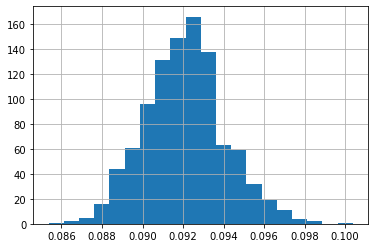

In [62]:
bootstraps.to_pandas().hist(bins=20)